## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Initial Data

In [1]:
import os
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
%matplotlib inline
0
# default folders
input_path = "test_images/"
output_path = 'output_images/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
video_output_path = 'test_videos_output/'
if not os.path.exists(video_output_path):
    os.makedirs(video_output_path)

# 1k smples
car_input_path = "classifier/vehicles_smallset/**/*.jpeg"
noncar_input_path = "classifier/non-vehicles_smallset/**/*.jpeg"

# 10k smples
car_input_path = "classifier/vehicles/**/*.png"
noncar_input_path = "classifier/non-vehicles/**/*.png"

print("Initialization done")

Initialization done


In [2]:
# General functions
def duplicate_image(img):
    '''
    Duplicates an image
    '''
    return np.copy(img)
    
def show_image(label, img, time=500):
    '''
    Shows an image
    '''
    cv2.imshow(label,img)
    cv2.waitKey(time)
    plt.imshow(img)

def compare_images(label1, img1, label2, img2):
    '''
    Compare two images
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    f.tight_layout()
    if len(img1.shape) < 3:
        ax1.imshow(img1, cmap='hot')
    else:
        ax1.imshow(img1)    
    ax1.set_title(label1, fontsize=20)
    if len(img2.shape) < 3:
        ax2.imshow(img2, cmap='hot')
    else:
        ax2.imshow(img2)
    ax2.set_title(label2, fontsize=20)    

def read_image(path):
    '''
    return an image based on the path provided
    '''
    image = mpimg.imread(path)
    if image.dtype == 'float32':
        image = convert_png_2_jpg(image)
    return image

def save_image(path, img):
    '''
    Saves an image in the specified folder
    '''
    plt.imsave(path, img)

def norm_image(img):
    '''
    Normalize the image
    '''
    return img.astype(np.float32)/255

def convert_png_2_jpg(img):
    '''
    Scale images as detailed https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/ea732214-fbc2-42b5-ad40-97a06a95b8ee
    .png(float32, bin range 0~1) to jpg(uint8, bin range 0~256)
    '''
    imag = img * 255
    image = imag.astype(np.uint8)
    return image
    
def visualize(fig, rows, cols, imgs, titles):
    '''
    Plotting multiple images, based on QA session
    https://www.youtube.com/watch?v=P2zwrTM8ueA&list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&index=5
    '''
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

def get_image_roi(image):
    '''
    return the Image Region of Interest
    '''
    return [np.int(image.shape[0]/2+30), image.shape[0]-60], [20, image.shape[1]-10]

def getImageFromCsvLine(row,sourceDirectory, filename, targetSize=(32,32)):
    '''
    Tentative function to be used with the kitty dataset

    '''
    image = cv2.imread(sourceDirectory + row[4])

    x1 = int(row[0])
    x2 = int(row[1])
    xmin = min(x1,x2) 
    xmax = max(x1,x2)
    y1 = int(row[2])
    y2 = int(row[3])    
    ymin = min(y1,y2)
    ymax = max(y1,y2)
    Label = row[5]
    image = image[xmin:xmax,ymin:ymax]
    # image = cv2.resize(image, targetSize, interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(filename,image)
    return image, Label

def readKiityImages(csv_path):
    '''
    Entry funcion for reading Kitty images
    '''
    with open(csv_path) as csvfile: # 'object-detection-crowdai/labels.csv'
        reader = csv.reader(csvfile)
        next(reader, None)
        for i in range (0,20):
            img, label = getImageFromCsvLine (next(reader,None),'object-detection-crowdai/','./' + str(i) + '.jpg')
            plt.figure()
            plt.title(label)
            plt.imshow(img)

print("Generic functions done")

Generic functions done


## HOG
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


## from https://discussions.udacity.com/t/vehicle-detection/450379/10
# Parameters where compared with this thread https://discussions.udacity.com/t/vehicle-detection/438697/11

colorspace = 'YCrCb' # Alternatives: RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11 # HOG orientations # 9 no change 16 # 11
pix_per_cell = 16 # HOG pixels per cell # 8 worst 16
cell_per_block = 2 # HOG cells per block # 4 worst
hog_channel = 'ALL' # Can be 0, 1, 2, or ALL
spatial_size = (16, 16) # Spatial binning dimensions # (32, 32) worst
hist_bins = 32 # Number of histogram bins # 16 worst
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
scale = 1.5

def convert_color(img, cspace='YCrCb'):
    feature_image = np.copy(img)
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    return feature_image

def bin_spatial(img, size=(32, 32)):
    '''
    compute binned color features
    '''
    r = cv2.resize(img[:,:,0], size).ravel()
    g = cv2.resize(img[:,:,1], size).ravel()
    b = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((r, g, b))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''
    compute color histogram features
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''
    return HOG features
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def openCV_hog(img, feature_vector):
    '''
    Using HOG from openCV for faster execution, taken from
    https://discussions.udacity.com/t/ways-to-improve-processing-time/237941/13
    '''
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    winSize = (img.shape[1],img.shape[0])
    blockSize = (2,2)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    hog = cv2.HOGDescriptor\
    (_winSize=(img.shape[1] // cellSize[1] * cellSize[1],\
    img.shape[0] // cellSize[0] * cellSize[0]),\
    _blockSize=(blockSize[1] * cellSize[1],\
    blockSize[0] * cellSize[0]),\
    _blockStride=(cellSize[1], cellSize[0]),\
    _cellSize=(cellSize[1], cellSize[0]),\
    _nbins=nbins)

    n_cells = (img.shape[0] // cellSize[0], img.shape[1] // cellSize[1])
    features = hog.compute(img)
    features = features.reshape(n_cells[1] - blockSize[1] + 1,\
    n_cells[0] - blockSize[0] + 1,\
    blockSize[0], blockSize[1], nbins) \
    .transpose((1, 0, 2, 3, 4)) # index blocks by rows first
    return features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Extract features pipeline from a list of images
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        image = read_image(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

def report(results, n_top=3):
    '''
    Utility function to report best scores
    '''
    best_c = 0.
    best_test_score = 0.
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean_test_score = np.float(results['mean_test_score'][candidate])
            std_test_score = np.float(results['std_test_score'][candidate])
            c_test_score = results['params'][candidate]
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(mean_test_score, std_test_score))
            print("Parameters: {0}".format(c_test_score))
            if mean_test_score > best_test_score:
                best_c = c_test_score
    return best_c

print("Specific functions done")

Specific functions done


## Classifier

In [4]:
print('Training started')

cars = []
notcars = []

'''
GTI* folders contain time-series data, so try to skip images to break this pattern.
'''
images = glob.glob(car_input_path, recursive=True)
for index in range(len(images)):
    #if index % 1 == 0:
    cars.append(images[index])
    
images = glob.glob(noncar_input_path, recursive=True)
for index in range(len(images)):
    #if index % 1 == 0:
    notcars.append(images[index])

t=time.time()
car_features = extract_features(cars, cspace=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print("{} seconds to extract HOG features...".format(round(t2-t, 2)))
# Define the stack of feature vectors and labels
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Min:{} Max:{}".format(X.min(), X.max()))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Grid search
svc = LinearSVC()
param_grid = [
  {'C': [1, 10, 100, 1000]},
  {'C': [0.0001, 0.001, 0.01, 0.1]},
]

grid_search = GridSearchCV(svc, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
c_value = report(grid_search.cv_results_)
#c_value = grid_search.cv_results_['params'][0]
print("Best C value: {}".format(c_value.get('C')))
svc.set_params(C=c_value.get('C'))
print("Classifier {}".format(svc))

print("Using: {} orientations {} pixels per cell and {} cells per block".format(orient, pix_per_cell, cell_per_block))
print("Feature vector length: {}".format(len(X_train[0])))

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("{} seconds to train SVC".format(round(t2-t, 2)))
print("Test Accuracy of SVC = {}".format(round(svc.score(X_test, y_test), 4)))
t=time.time()
n_predict = 10
print("My SVC predicts: {}".format(svc.predict(X_test[0:n_predict])))
print("For these {} labels: {}".format(n_predict, y_test[0:n_predict]))
t2 = time.time()
print("{} seconds to predict {} labels with SVC".format(round(t2-t, 5), n_predict))

print("Dataset: {} cars, {} non_cars, {} for training, {} for test".format(len(cars), len(notcars), len(X_train), len(X_test)))
print('Training ended')

Training started
70.85 seconds to extract HOG features...
Min:0.0 Max:4096.0
GridSearchCV took 63.37 seconds for 8 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.991 (std: 0.001)
Parameters: {'C': 0.001}
Model with rank: 2
Mean validation score: 0.991 (std: 0.001)
Parameters: {'C': 0.01}
Model with rank: 3
Mean validation score: 0.990 (std: 0.000)
Parameters: {'C': 0.1}
Best C value: 0.1
Classifier LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
5.4 seconds to train SVC
Test Accuracy of SVC = 0.9887
My SVC predicts: [1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
For these 10 labels: [1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
0.00059 seconds to predict 10 labels with SVC
Dataset: 8792 cars, 8968 non_cars, 14208 for training, 3552 f

Check features on a random car


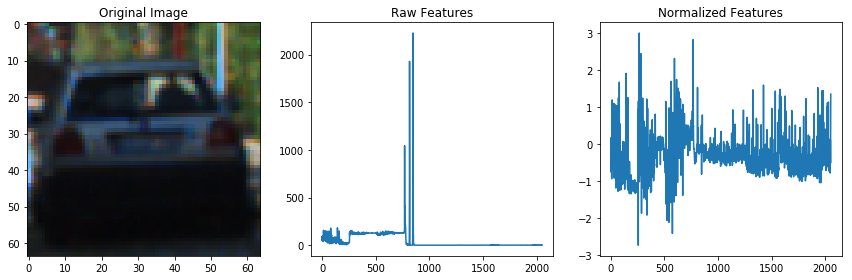

In [5]:
print('Check features on a random car')

car_ind = np.random.randint(0, min(len(notcars), len(cars)))
car_image = read_image(cars[car_ind])

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


## HOG2
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

In [6]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    '''
    return a list of windows matching the prediction    
    '''
    on_windows = []
    for window in windows:
        if window is None:
            continue
    
        try:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        except:
            continue
            
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        scaled_features = np.array(features).reshape(1, -1)
        test_features = scaler.transform(scaled_features)
        prediction = clf.predict(test_features)
        confidence = clf.decision_function(test_features)
        if prediction == 1 and confidence >= 1.0: # possitive prediction
            #print(clf.decision_function(test_features))
            on_windows.append(window)
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    '''
    Extract all features at once for one image
    '''
    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)            
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        img_features.append(hog_features)
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    '''
    Based on an image, start and stop positions in both x and y and window size, returns a list of windows to search
    '''
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1 # np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step) - 1 # np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    '''
    Draw bounding boxes
    '''
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

print("Pipeline functions done")

Pipeline functions done


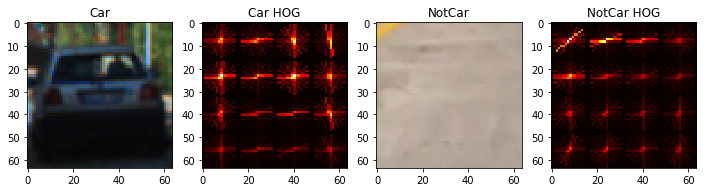

In [7]:
# Visualize HOG
_, car_hog_image = single_img_features(car_image, color_space='RGB', 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=0, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_image = read_image(notcars[car_ind])
_, notcar_hog_image = single_img_features(notcar_image, color_space='RGB', 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=0, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['Car', 'Car HOG', 'NotCar', 'NotCar HOG']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)


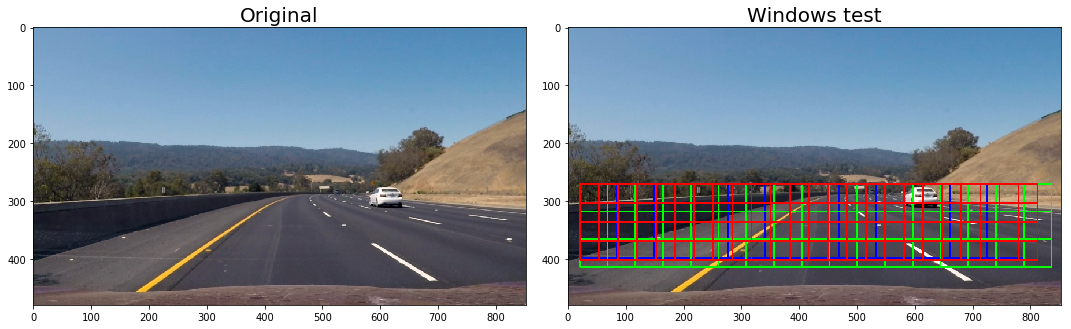

In [8]:
# Test SlideWindow

sample_image = 'test3.jpg'
#sample_image = 'test6.jpg'
sample_path = 'test_images/' + sample_image
image = read_image(sample_path)
#image = norm_image(image)

if scale != 1:
    imshape = image.shape
    image = cv2.resize(image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    

y_start_stop, x_start_stop = get_image_roi(image)

w1 = slide_window(image, y_start_stop=y_start_stop, x_start_stop=x_start_stop, xy_window=(128, 128))
window_img = draw_boxes(image, w1, color=(0, 0, 255), thick=2)
w2 = slide_window(image, y_start_stop=y_start_stop, x_start_stop=x_start_stop, xy_window=(96, 96))
window_img = draw_boxes(window_img, w2, color=(0, 255, 0), thick=2)
w3 = slide_window(image, y_start_stop=y_start_stop, x_start_stop=x_start_stop, xy_window=(66, 66))    
window_img = draw_boxes(window_img, w3, color=(255, 0, 0), thick=2)

compare_images("Original", image, 'Windows test', window_img)



## Pipeline on images only
Apply the pipeline an all test images

processing 6 test images
Main pipeline done, check output folder for detail


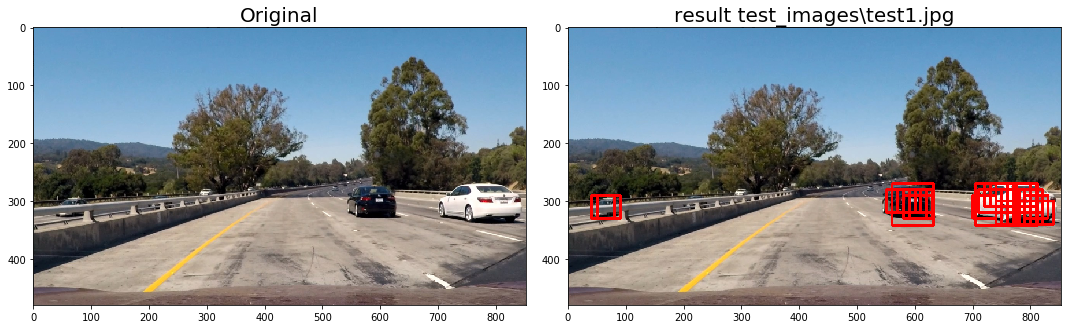

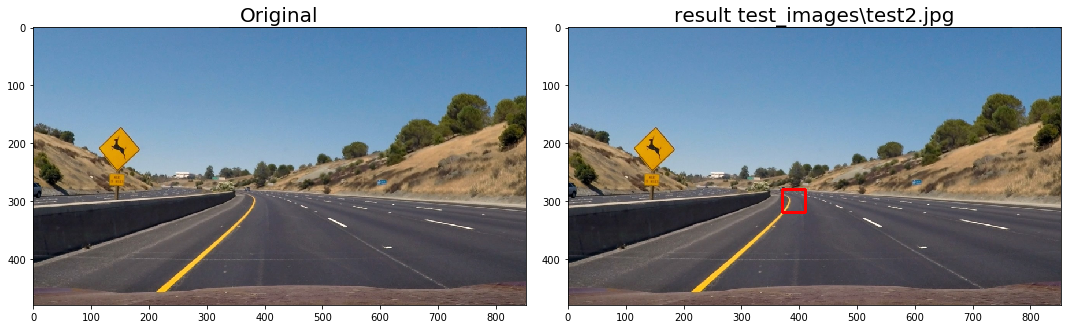

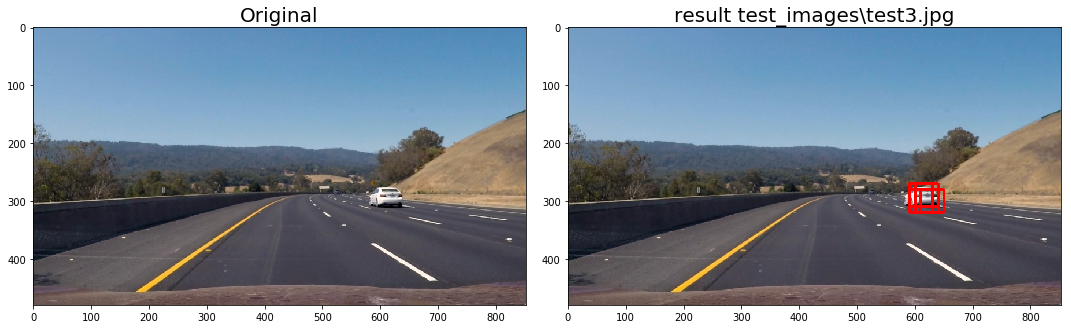

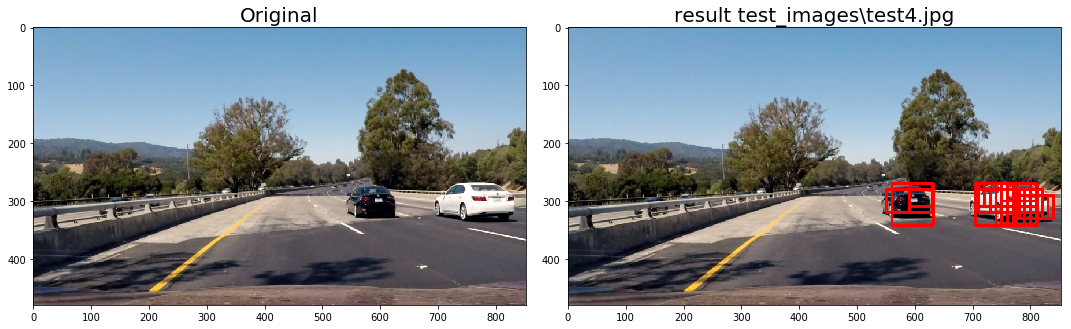

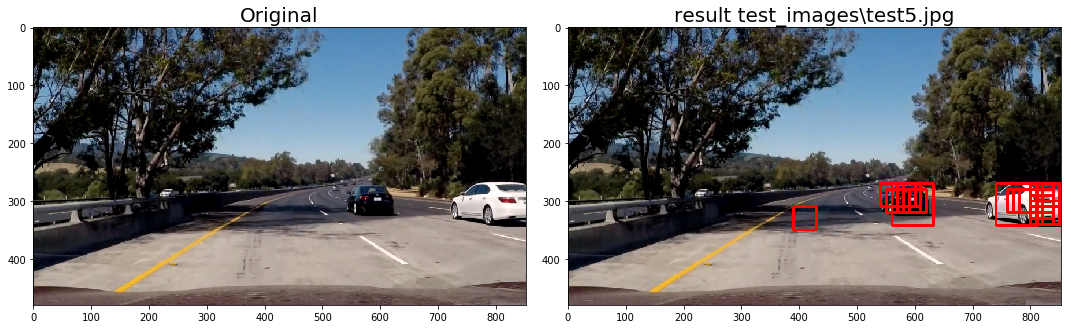

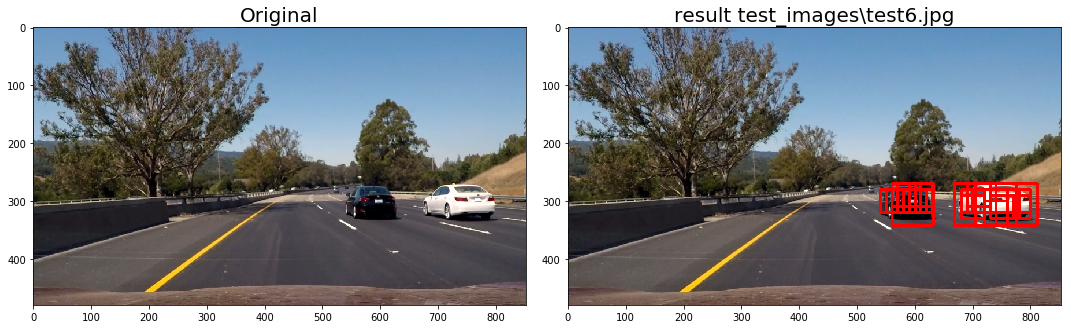

In [9]:
def getROIWindows(image, y_start_stop, x_start_stop):
    '''
    Get a list of windows to search based on the Region of Interest
    '''    
    w1, w2, w3, w4 = [], [], [], []
    w1 = slide_window(image, xy_window=(40, 40), xy_overlap=(0.75, 0.75), y_start_stop=(np.int(image.shape[0]/2+30), np.int(image.shape[0]*3/4)), x_start_stop=x_start_stop)
    #w2 = slide_window(image, xy_window=(60, 60), xy_overlap=(0.5, 0.5), y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    w3 = slide_window(image, xy_window=(72, 72), xy_overlap=(0.5, 0.5), y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    #w4 = slide_window(image, xy_window=(85, 85), xy_overlap=(0.5, 0.5), y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    windows = w1 + w2 + w3 + w4
    return windows

def processImg(image):
    '''
    Initial pipeline to process images
    '''    
    y_start_stop, x_start_stop = get_image_roi(image)
    
    draw_image = np.copy(image)
    
    windows = getROIWindows(image, y_start_stop, x_start_stop)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=4)
    return window_img

import glob

test_images = glob.glob(input_path+'test*.jpg')
print("processing {} test images".format(len(test_images)))

img_count = 0
# Main execution
for item in test_images:

    img_count += 1

    current_image = read_image(item)

    current_image_shape = current_image.shape
    
    if scale != 1:
        current_image = cv2.resize(current_image, (np.int(current_image.shape[1]/scale), np.int(current_image.shape[0]/scale) ) )

    result = processImg(current_image)
    
    outputResult = result

    path = "{}img{}.jpg".format(output_path, img_count)
    save_image(path, outputResult)
    compare_images("Original", current_image, 'result {}'.format(item), outputResult)
    #break # To debug just one image

print("Main pipeline done, check output folder for detail")

## Heatmap
Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

Pipeline with Heatmap done, check output folder for detail


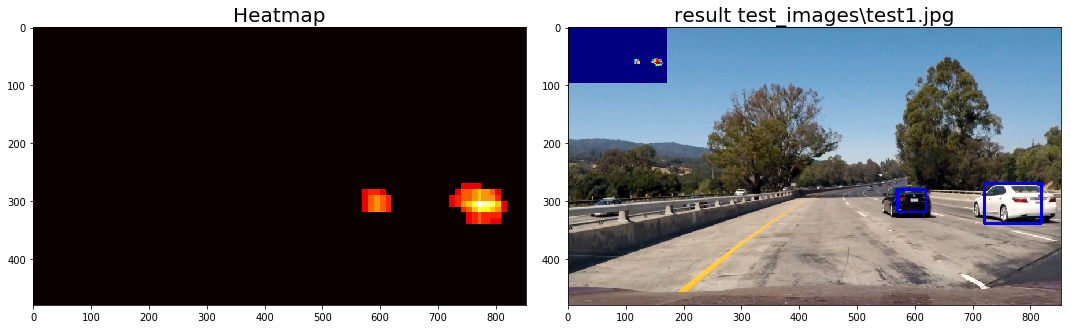

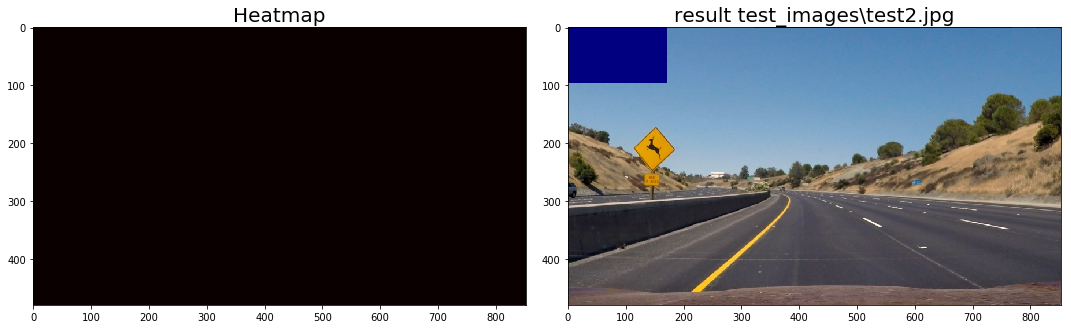

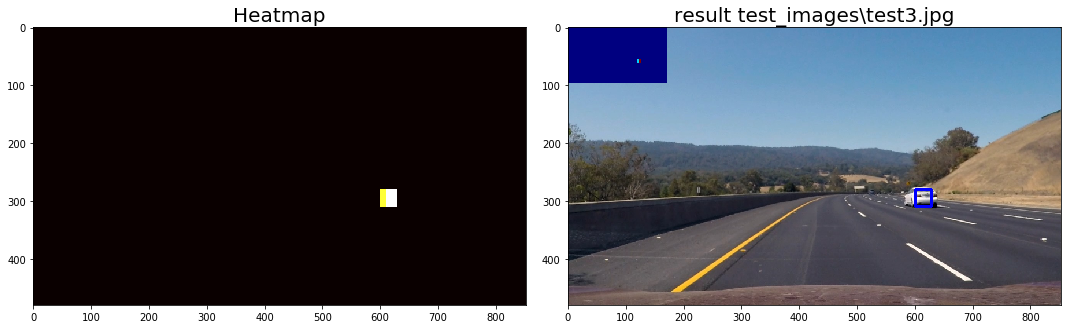

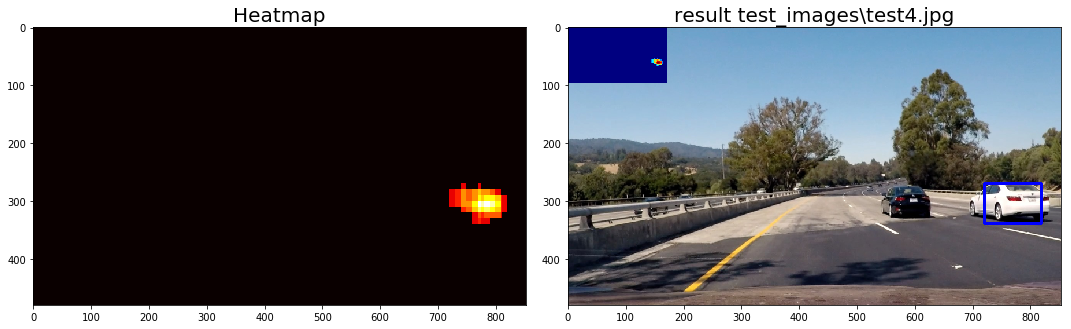

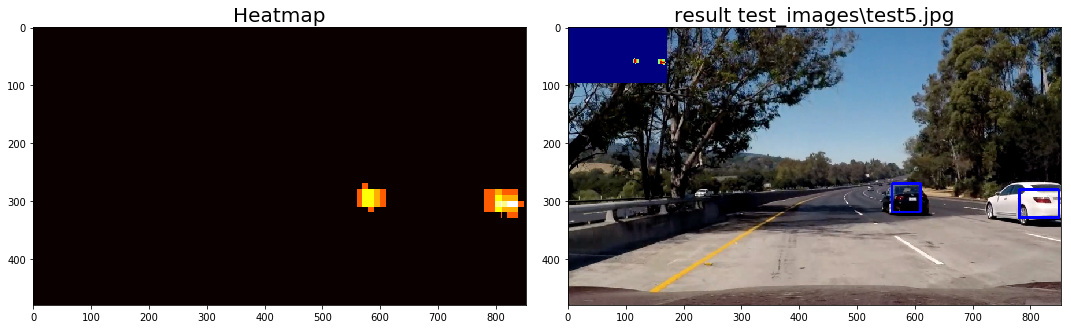

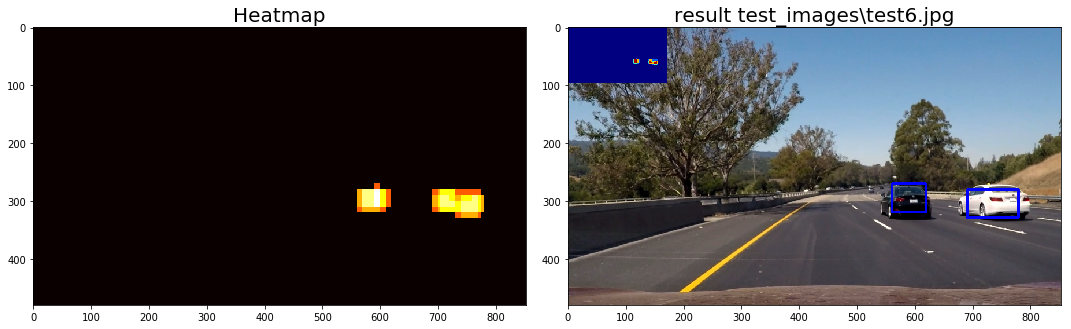

In [36]:
# Heat map gets away with the false positives

def complete_pipeline(img, average_heatmap=False):
    '''
    Complete image pipeline + Heatmap
    '''
    ctrans_tosearch = np.copy(img)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    

    draw_image = np.copy(ctrans_tosearch)
        
    y_start_stop, x_start_stop = get_image_roi(ctrans_tosearch)
    
    windows = getROIWindows(ctrans_tosearch, y_start_stop, x_start_stop)

    on_windows = search_windows(ctrans_tosearch, windows, svc, X_scaler, color_space=colorspace, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_image, on_windows, color=(255, 0, 0), thick=4)
    
    heatmap = np.zeros_like(ctrans_tosearch[:, :, 0]).astype(np.float)
    heatmap = add_heat(heatmap, on_windows)
    if average_heatmap == True: # Accumulate data between frames
        heatmaps.append(heatmap)
        heatmap_sum = sum(heatmaps)
        heat = apply_threshold(heatmap_sum, 21.)
    else:
        heat = apply_threshold(heatmap, 3.)

    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    boxed_image = draw_labeled_bboxes(draw_image, labels)

    return boxed_image, heatmap, window_img 

def add_heat_with_history(heatmap, bbox_list_with_history):
    # Iterate through list of bboxes
    for bbox_list in bbox_list_with_history:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0, 0, 255), thick=4):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    return img

def compose_image(first_image, second_image):
    '''
    Compose two images
    https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
    '''
    img2 = cv2.resize(second_image, (0,0), fx=0.2, fy=0.2) # 20%
    rows = img2.shape[0]
    cols = img2.shape[1]
    roi = first_image[0:rows, 0:cols]
    # Now create a mask of thumbnail and create its inverse mask also
    if len(img2.shape) < 3:
        img2 = colorHeatMap(img2, cmap=cv2.COLORMAP_JET)
            
    img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the thumbnail in ROI
    first_image_bg = cv2.bitwise_and(roi, roi, mask = mask_inv)
    # Take only thumbnail region.
    img2_fg = cv2.bitwise_and(img2, img2, mask = mask)
    # Put thumbnail in ROI and modify the main image
    dst = cv2.add(first_image_bg, img2)
    first_image[0:rows, 0:cols] = dst
    return first_image

def colorHeatMap(heatMapMono, cmap=cv2.COLORMAP_HOT):
    '''
    Makes an RGB version of the 1-channel heatMap
    '''
    heatMapInt = cv2.equalizeHist(heatMapMono.astype(np.uint8))
    heatColor = cv2.applyColorMap(heatMapInt, cmap)
    heatColor = cv2.cvtColor(heatColor, code=cv2.COLOR_BGR2RGB)
    return heatColor
    
# Sample pipeline
from collections import deque
heatmaps = deque(maxlen=7)

# Main execution
img_count = 0
for item in test_images:
    current_image = read_image(item)
    img_count += 1

    result, heatmap, window_img = complete_pipeline(current_image)
    result = compose_image(result, heatmap)

    path = "{}img2_{}.jpg".format(output_path, img_count)
    save_image(path, result)
    compare_images("Heatmap", heatmap, 'result {}'.format(item), result)
    
    #break # To debug just one image

print("Pipeline with Heatmap done, check output folder for detail")

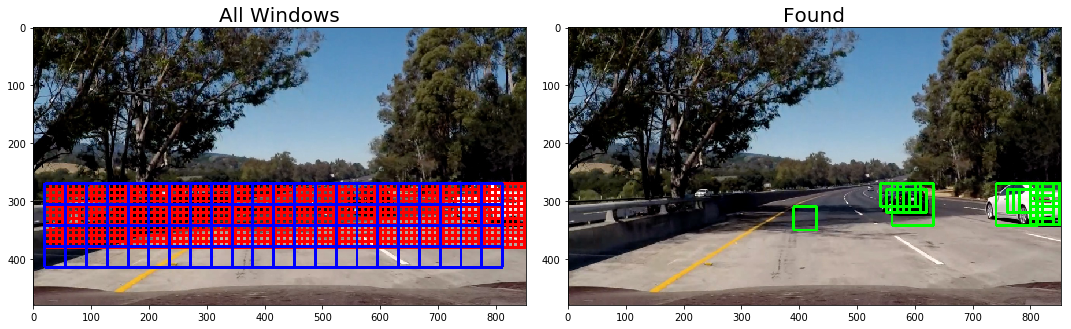

In [26]:
# Test items separately

sample_image = 'test3.jpg'
sample_image = 'test5.jpg'
sample_path = 'test_images/' + sample_image
image = read_image(sample_path)

if scale != 1:
    image = cv2.resize(image, (np.int(image.shape[1]/scale), np.int(image.shape[0]/scale)))

y_start_stop, x_start_stop = get_image_roi(image)

draw_image = np.copy(image)

# Windows search strategy
w1 = slide_window(image, xy_window=(40, 40), xy_overlap=(0.75, 0.75), y_start_stop=(np.int(image.shape[0]/2+30), np.int(image.shape[0]*3/4)), x_start_stop=x_start_stop)
w3 = slide_window(image, xy_window=(72, 72), xy_overlap=(0.5, 0.5), y_start_stop=y_start_stop, x_start_stop=x_start_stop)
windows = w1 + w3

window_img_all = draw_boxes(draw_image, w1, color=(255, 0, 0), thick=3)
window_img_all = draw_boxes(window_img_all, w3, color=(0, 0, 255), thick=3)

# Search
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=3)
compare_images("All Windows", window_img_all, 'Found', window_img)

## Video

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def video_pipeline(current_image):
    '''
    Complete video pipeline
    '''

    result, heatmap, window_img = complete_pipeline(current_image, average_heatmap=True)
    result = compose_image(result, heatmap)
    return result

def generate_video(output_path, video_name, process_image):
    '''
    Generate a video
    '''
    debug = True
    
    output = output_path + video_name

    clip1 = VideoFileClip(video_name)#.subclip(33,38) # 9,11 # 20,25 # 33,38
    video_clip = clip1.fl_image(process_image)
    %time video_clip.write_videofile(output, audio=False)

    if debug is True:
        extract_frames(clip1, output_path)
    
    clip1.reader.close()
    clip1.audio.reader.close_proc()
    
    return output

def extract_frames(clip, output_path):
    '''
    Extract some images from a video
    '''
    times = 0.1, 0.5, 0.9
    for t in times:
        imgpath = os.path.join(output_path, '{}.png'.format(t))
        clip.save_frame(imgpath, t)

print("Video functions done")

Video functions done


### First Video

In [12]:
first_output = generate_video(video_output_path, 'test_video.mp4', video_pipeline)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:39<00:02,  2.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 1min 40s


Inline video

In [13]:
HTML("""
<video width="680" height="480" controls>
  <source src="{0}">
</video>
""".format(first_output))

### Second video

In [41]:
second_output = generate_video(video_output_path, 'project_video.mp4', video_pipeline)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [55:57<00:02,  2.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 55min 58s


In [42]:
HTML("""
<video width="680" height="480" controls>
  <source src="{0}">
</video>
""".format(second_output))